In [2]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [3]:
import group_data as gd

In [8]:
def get_coher(img_ser,rwing_ser,basline_scalar,NFFT = 2**12):
    #from numpy import ones,zeros,hanning
    import numpy as np
    #from numpy import fft
    from scipy import signal
    from matplotlib import mlab
    
    df_f_ser = (img_ser-basline_scalar)/basline_scalar

    f,Pxx = signal.welch(df_f_ser,fs = 1/0.0450)
    f,Pyy = signal.welch(rwing_ser,fs = 1/0.0450)
    f,Pxy = mlab.csd(df_f_ser,rwing_ser,Fs = 1/0.0450)[::-1]
    f,Cxy = mlab.cohere(df_f_ser,rwing_ser,Fs = 1/0.0450)[::-1]
    return Pxx,Pyy,Pxy,Cxy,f

In [33]:
### set up the cluster
from IPython.parallel import Client
clients = Client(profile='nbserver') 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [34]:
def calc_spectral_stats(fly,sig_type = 'rwing'):
    print fly.fly_path
    import os
    if os.path.exists(fly.fly_path+ 'epoch_data.cpkl'):
        import h5py
        fly_record = h5py.File(fly.fly_path + 'fly_record.hdf5')
        imgs = np.array(fly_record['experiments'].values()[0]['tiff_data']['images'])
        import cPickle
        fi = open(fly.fly_path + 'epoch_data.cpkl')
        epch_data = cPickle.load(fi)
        fi.close()
        ### extract the signals of interest
        baseline_F = np.mean(imgs[epch_data['baseline_F'][0]:epch_data['baseline_F'][1],:,:].astype(float),axis = 0)
        sigs = fly_record['experiments'].values()[0]['tiff_data']['axon_framebase']
        wfreq = np.array(sigs['wb_frequency'])
        rwing = np.array(sigs['Ph1'])
        idx = (np.array(sigs['StimCond']) < 0) & (wfreq > 100)

        ### create a mapable data set
        X,Y = np.meshgrid(*[np.arange(x) for x in np.shape(imgs[0])])
        pairs = zip(X.ravel(),Y.ravel())
        tl = np.shape(imgs)[0]
        PX = [np.array(imgs[idx[0:tl],x,y]) for x,y in pairs]
        
        if sig_type == 'rwing':
            WA = [np.array(rwing[idx[0:tl]]) for x,y in pairs]
        else:
            WA = [np.array(wfreq[idx[0:tl]]) for x,y in pairs]
            
        BA = [baseline_F[x,y] for x,y in pairs]
        NFFT = [2**8 for x,y in pairs]
        ### map the data
        spectral_data = v.map(get_coher,PX,WA,BA,NFFT)
        sdata = np.array(spectral_data)
        save_dict = dict()
        ### extract the data
        save_dict['df_f_psd'] = transpose(sdata[:,0,:].reshape(174,130,-1),(2,1,0))
        save_dict['wing_psd'] = transpose(sdata[:,1,:].reshape(174,130,-1),(2,1,0))
        save_dict['df_f_wing_csd'] = transpose(sdata[:,2,:].reshape(174,130,-1),(2,1,0))
        save_dict['df_f_wing_coherence'] = transpose(sdata[:,3,:].reshape(174,130,-1).astype(float),(2,1,0))
        save_dict['spectral_frequencies'] = transpose(sdata[:,4,:].reshape(174,130,-1).astype(float),(2,1,0))
        
        print save_dict['spectral_frequencies'][0][0][0],save_dict['spectral_frequencies'][-1][0][0]
        ### save the data
        if sig_type == 'rwing':
            fl = open(fly.fly_path + 'spectral_data_rwing.cpkl','wb')
        else:
            fl = open(fly.fly_path + 'spectral_data_freq.cpkl','wb')
            
        cPickle.dump(save_dict,fl)
        fl.close()
    else:
        print 'no epoch data'

In [ ]:
#import shutil
#import os
#for swarm in gd.swarms.values():
#    for fly in swarm.flies:
#        if os.path.exists(fly.fly_path + 'spectral_data.cpkl'):
#            print fly.fly_num
#            os.remove(fly.fly_path + 'spectral_data.cpkl')
#            #shutil.copy2(fly.fly_path + 'spectral_data.cpkl',fly.fly_path + 'spectral_data_rwing.cpkl')

In [35]:
def update_spectral_stats(replace = False):
    import os
    for swarm_name,swarm in gd.swarms.items():
        print swarm_name
        for fly in swarm.flies:
            try:
                if not(replace):
                    if os.path.exists(fly.fly_path + 'spectral_data_rwing.cpkl'):
                        print str(fly.fly_num) + ' exists'
                        #calc_spectral_stats(fly,sig_type = 'freq')
                        #calc_spectral_stats(fly,sig_type = 'rwing')
                    else:
                        print 'calculating frequency spectral stats on %s'%(fly.fly_num)
                        calc_spectral_stats(fly,sig_type = 'freq')
                        print 'calculating amplitude spectral stats on %s'%(fly.fly_num)
                        calc_spectral_stats(fly,sig_type = 'rwing')
                else:
                    #print 'replace'
                    calc_spectral_stats(fly,sig_type = 'freq')
            except Error as er:

In [36]:
update_spectral_stats()

GMR31E10_GFP
calculating frequency spectral stats on 361
/media/FlyDataC/FlyDB/Fly0361/
0.0 11.1111111111
calculating amplitude spectral stats on 361
/media/FlyDataC/FlyDB/Fly0361/
0.0 11.1111111111
calculating frequency spectral stats on 362
/media/FlyDataC/FlyDB/Fly0362/
0.0 11.1111111111
calculating amplitude spectral stats on 362
/media/FlyDataC/FlyDB/Fly0362/
0.0 11.1111111111
calculating frequency spectral stats on 363
/media/FlyDataC/FlyDB/Fly0363/
0.0 11.1111111111
calculating amplitude spectral stats on 363
/media/FlyDataC/FlyDB/Fly0363/
0.0 11.1111111111
calculating frequency spectral stats on 364
/media/FlyDataC/FlyDB/Fly0364/
0.0 11.1111111111
calculating amplitude spectral stats on 364
/media/FlyDataC/FlyDB/Fly0364/
0.0 11.1111111111
calculating frequency spectral stats on 365
/media/FlyDataC/FlyDB/Fly0365/
0.0 11.1111111111
calculating amplitude spectral stats on 365
/media/FlyDataC/FlyDB/Fly0365/
0.0 11.1111111111
calculating frequency spectral stats on 384
/media/FlyDat

/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


In [39]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_image(fly,img,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_swarm_imgs(swarm):
    swarm_imgs = {'csd_mag':list(),
                'csd_phase':list(),
                'df_f_psd':list(),
                'df_f_wing_coherence':list()}

    for fly in swarm.flies:
        try:
            spectral_data = fly.get_pkl_data('spectral_data_rwing.cpkl')
            bandwidth = 1
            freqs = spectral_data['spectral_frequencies'][:,0,0]
            freq_res = freqs[1] - freqs[0]
            num_freqs = np.shape(freqs)[0]
            idx_interval = np.floor(bandwidth/freq_res)
            idx_intervals = np.arange(1,num_freqs,idx_interval).astype(int)
            idx_bands = [(x,y) for x,y in zip(idx_intervals[:-1],idx_intervals[1:])]
            bands = [(freqs[x],freqs[y]) for x,y in idx_bands]
            
            data = np.angle(spectral_data['df_f_wing_csd'])
            data = (data>0)*(-2*pi+data) + (data<0)*(data)
            img_list = list()
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['csd_phase'].append(img_list)
            
            img_list = list()
            data = np.abs(spectral_data['df_f_wing_csd'])
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['csd_mag'].append(img_list)
            
            img_list = list()
            data = np.abs(spectral_data['df_f_psd'])
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['df_f_psd'].append(img_list)
            
            img_list = list()
            data = np.abs(spectral_data['df_f_wing_coherence'])
            for idx,band in zip(idx_bands,bands):
                img = np.mean(data[idx[0]:idx[1]],axis = 0)
                img_list.append(warp_fly_image(fly,img))
            swarm_imgs['df_f_wing_coherence'].append(img_list)

        except IOError:
            print 'IOError:%s'%(fly.fly_num)
    return swarm_imgs
            #imshow(warp_fly_image(fly,img),cmap = cm.gray)
            #gca().set_title(str(band))

In [78]:
swarm_imgs = get_swarm_imgs(gd.swarms['GMR10A12'])

/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: invalid value encountered in greater
/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: invalid value encountered in less


In [92]:
shape(swarm_imgs['csd_mag'])

(12, 11, 1024, 1024)

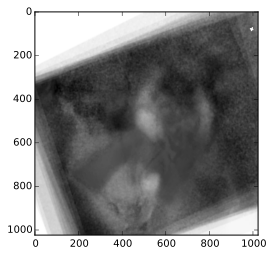

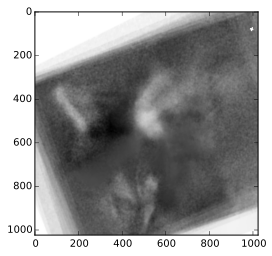

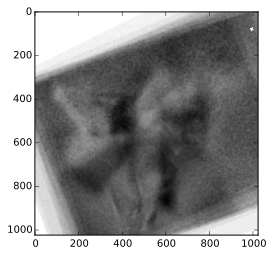

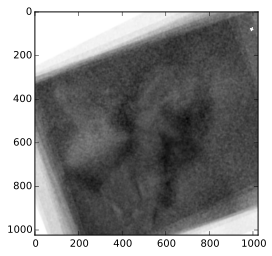

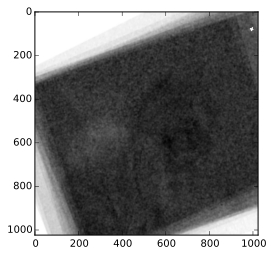

In [91]:
fimgs = np.array(swarm_imgs['csd_phase'])
for img in np.mean(fimgs,axis = 0)[:5]:
    figure()
    #img = np.mean(fimgs,axis = 0)[0]
    #img = (img>0)*(-2*pi+img) + (img<0)*(img)
    #img = (img < pi)*img + (img > pi)*(mod(img,pi)*-1)
    imshow(img,cmap = cm.gray)#,vmin = -1.5*pi,vmax = 0)

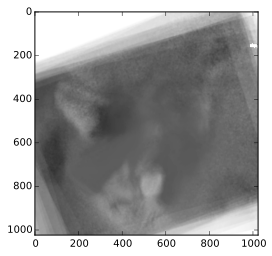

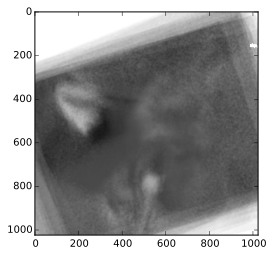

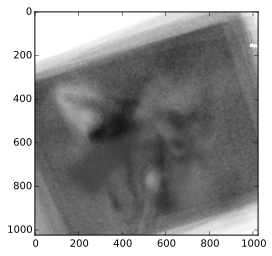

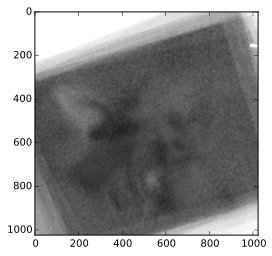

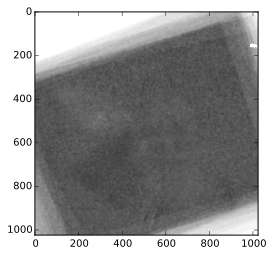

In [77]:
fimgs = np.array(swarm_imgs['csd_phase'])
for img in np.mean(fimgs,axis = 0)[:5]:
    figure()
    #img = np.mean(fimgs,axis = 0)[0]
    #img = (img>0)*(-2*pi+img) + (img<0)*(img)
    #img = (img < pi)*img + (img > pi)*(mod(img,pi)*-1)
    imshow(img,cmap = cm.gray,vmin = -1.5*pi,vmax = 0)

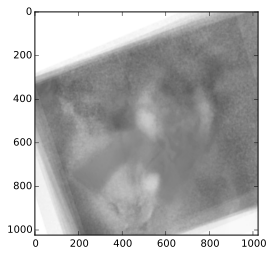

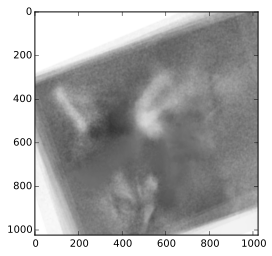

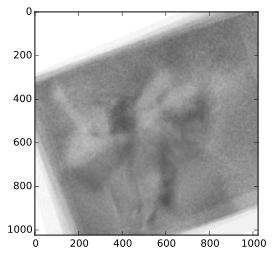

In [96]:
fimgs = np.array(swarm_imgs['csd_phase'])
for img in np.mean(fimgs,axis = 0)[:3]:
    figure()
    #img = np.mean(fimgs,axis = 0)[0]
    #img = (img>0)*(-2*pi+img) + (img<0)*(img)
    #img = (img < pi)*img + (img > pi)*(mod(img,pi)*-1)
    imshow(img,cmap = cm.gray,vmin = -2*pi,vmax = 0)

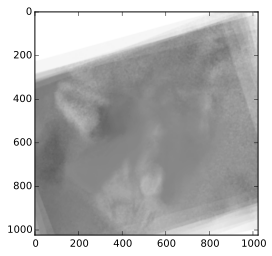

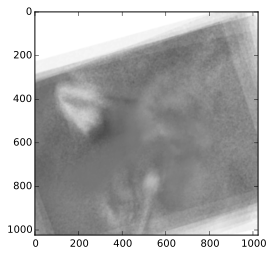

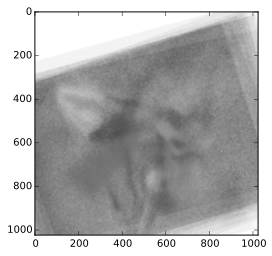

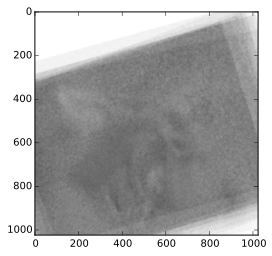

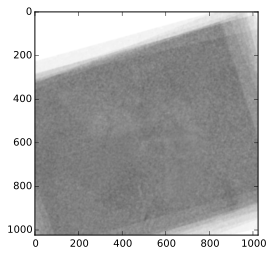

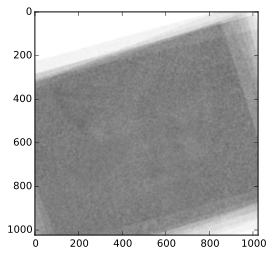

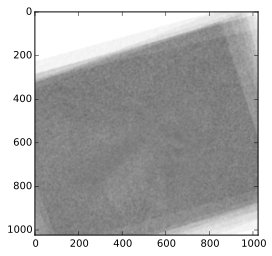

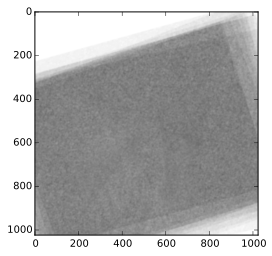

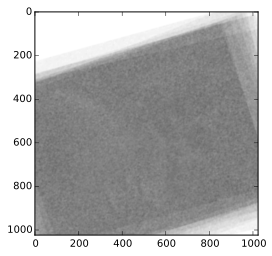

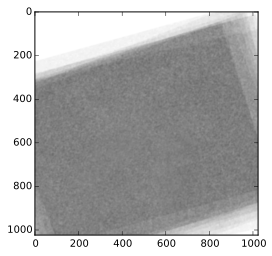

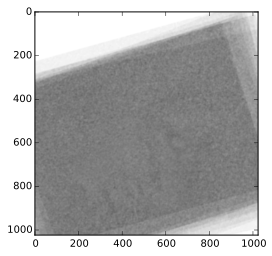

In [74]:
for img in np.mean(fimgs,axis = 0):
    figure()
    #img = np.mean(fimgs,axis = 0)[0]
    #img = (img>0)*(-2*pi+img) + (img<0)*(img)
    #img = (img < pi)*img + (img > pi)*(mod(img,pi)*-1)
    imshow(img,cmap = cm.gray,vmin = -2*pi,vmax = 0)

(array([  92233.,   15435.,       0.,       0.,       0.,       0.,
              0.,   21860.,  361718.,  557330.]),
 array([-6.28318223, -5.65486401, -5.02654578, -4.39822756, -3.76990934,
        -3.14159111, -2.51327289, -1.88495467, -1.25663645, -0.62831822,  0.        ]),
 <a list of 10 Patch objects>)

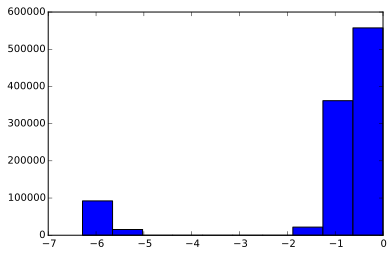

In [65]:
hist(img.ravel())

-2.8831853071795863

In [34]:
(mod(x,pi) < pi)

True